# Comparing Green and Thomas (2013) sampler to the Parallel sampler

This results depends on [Benchpress](https://github.com/felixleopoldo/benchpress) output


In [5]:
## general setup
BENCHPRESS_LOC = '/home/mo/src/benchpress/results/adjvecs/'
OUTPUTLOC = '~/src/'
BENCHPRESS_LOC = OUTPUTLOC
SAVE_PLOTS = False
SAVE_LOC =  '~/src/'
RUN_MODELS = False
## model constants
SEED_RANGE = list(range(10))
P = 50
SIGMA2 = 1.0
RHO= 0.9
N = 100
DELTA = 5
OUTPUT_FORMAT='benchpress'

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('..')
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib
import parallelDG.auxiliary_functions as aux
from parallelDG import mh_greenthomas
from parallelDG import mh_parallel
import parallelDG.distributions.g_intra_class as gic
import parallelDG.graph.decomposable as dlib
sns.set_style("whitegrid")

In [4]:
def list_with_pattern(pat, ls):
    return [l for l in ls if pat in l]

def algo_files(location, algo_name = 'parallleDG', pattern=None): 
    filelist = []
    for root, dir, files in os.walk(BENCHPRESS_LOC): 
        for file in files: 
            filelist.append(os.path.join(root,file))
    
    alg = algo_name
    fl = list_with_pattern(alg, filelist)
    if pattern: 
        if type(pattern) is list: 
            final_ls = fl
            for p in pattern: 
                final_ls = list_with_pattern(p, final_ls)
            return final_ls
        else:
            return list_with_pattern(pattern, fl)
    else: 
        return fl
    

def edges_str_to_list(str, edgesymb="-"):
    edges_str = str[1:-1].split(";")
    edges = [(edge.split(edgesymb)[0], edge.split(edgesymb)[1])
             for edge in edges_str if len(edge.split(edgesymb)) == 2]
    return edges

def size_traj(filename):
    edgesymb = "-"
    g = nx.Graph()
    size = []
    df = pd.read_csv(filename, sep=",")
    
    if 'subindex' in df.columns: 
        df.rename(columns={'added_sub': 'added', 
                           'subindex': 'index', 
                          'removed_sub': 'removed'}
                  , inplace=True)
    
    for index, row in df.iterrows():
            added = edges_str_to_list(row["added"], edgesymb)
            removed = edges_str_to_list(row["removed"], edgesymb)
            g.add_edges_from(added)
            g.remove_edges_from(removed)
            size.append(g.size())
    df["size"] = size
    T = df["index"].iloc[-1]  # approximate length
    newindex = pd.Series(range(T))
    # removes the two first rows.
    df2 = df[["index", "size"]][2:].set_index("index")
    df2 = df2.reindex(newindex).reset_index().reindex(
        columns=df2.columns).fillna(method="ffill")
    return df2

def size_traj_plot(filename): 
    df = size_traj(filename)
    df["size"].plot()
    plt.tight_layout()
    plt.xlabel('Sample number')
    plt.ylabel('Number of graph edges')
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    #plt.savefig(snakemake.output["plot"])


def score_traj_plot(filename): 
    edgesymb = "-"
    g = nx.Graph()
    df = pd.read_csv(filename, sep=",")
    T = df["index"].iloc[-1]  # approximate length

    newindex = pd.Series(range(T))
      # removes the two first rows.
    df2 = df[["index", "score"]][2:].set_index("index")
    df2 = df2.reindex(newindex).reset_index().reindex(
        columns=df2.columns).fillna(method="ffill")
    df2["score"].plot()
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    plt.ylabel('Log-likelihood')
    plt.xlabel('Sample number')
    plt.tight_layout()
    return df2
    #plt.savefig(snakemake.output["plot"])
    
    
def autocorrelation(traj, lag):
    return aux.autocorrelation_plot(traj,lag = lag,
                                 return_series=True)

def acceptance_ratio(traj):
    dx = (np.diff(traj)!=0) * 1.0
    ar = np.mean(dx, dtype=float)
    par = np.cumsum(dx, dtype=float)/(np.array(range(len(dx))) + 1.0)
    print('Acceptance ratio {:2f}'.format(ar))
    return ar, par

def save_location(filename, loc = SAVE_LOC):
    if SAVE_PLOTS:
        plt.savefig(loc + filename + '.png', dpi = 600, bbox_inches='tight')
    else: 
        plt.show()

In [4]:
### RUNING THOMAS & GREEN CODE
if RUN_MODELS: 
    for s in SEED_RANGE:
        np.random.seed(s)
        ar_graph = dlib.sample_random_AR_graph(n_dim=P, max_bandwidth=DELTA)
        ar_cov_mat = gic.cov_matrix(ar_graph, RHO, SIGMA2)
        ar_df = pd.DataFrame(np.random.multivariate_normal(np.zeros(P), ar_cov_mat, N))
        mh_greenthomas.sample_trajectories_ggm_to_file(ar_df, 
                                                       n_samples=[1000000], 
                                                       randomize=[100],
                                                       delta=  DELTA,
                                                       reps=1,
                                                       seed=s,
                                                       output_format = OUTPUT_FORMAT,
                                                       output_directory=OUTPUTLOC +"gt13/")


In [5]:
### RUNING parallelDG code
if RUN_MODELS: 
    for s in SEED_RANGE:
        np.random.seed(s)
        ar_graph = dlib.sample_random_AR_graph(n_dim=P, max_bandwidth=DELTA)
        ar_cov_mat = gic.cov_matrix(ar_graph, RHO, SIGMA2)
        ar_df = pd.DataFrame(np.random.multivariate_normal(np.zeros(P), ar_cov_mat, N))
        mh_parallel.sample_trajectories_ggm_to_file(ar_df, 
                                                       n_samples=[500000], 
                                                       randomize=[100],
                                                       delta=  [DELTA],
                                                       reps=1,
                                                       graph_prior = ['uniform'],
                                                       seed=s,
                                                       output_format = OUTPUT_FORMAT,
                                                       output_directory=OUTPUTLOC +"parallelDG/")

In [5]:
## Extrat location of datafile
paralleldg_files = algo_files(BENCHPRESS_LOC, 'parallel', ['graph_traj'])
paralleldg_files = [f for f in paralleldg_files if 'subindex' not in f]
paralleldg_files_sub = algo_files(BENCHPRESS_LOC, 'parallel', ['subindex.csv'])
gt_files = algo_files(BENCHPRESS_LOC, 'gt13', ['graph_traj_'])
gt_files = [f for f in gt_files if 'subindex' not in f]

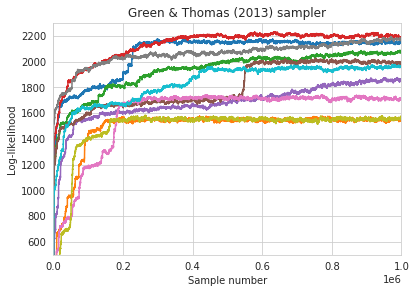

In [28]:
for f in gt_files:
    score_traj_plot(f)
plt.ylim((500, 2300))
plt.title('Green & Thomas (2013) sampler')
save_location('gt_loglikelihood_10_traj')

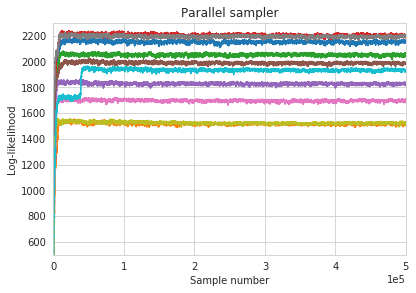

In [29]:
for f in paralleldg_files:
    score_traj_plot(f)
plt.ylim((500,2300))
plt.title('Parallel sampler')
save_location('parallel_loglikelihood_10_traj')

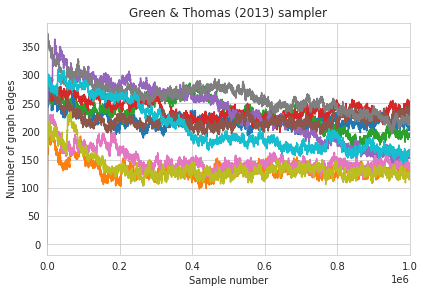

In [30]:
for f in gt_files:
    size_traj_plot(f)
plt.title('Green & Thomas (2013) sampler')
save_location('gt_size_traceplot_10_traj')

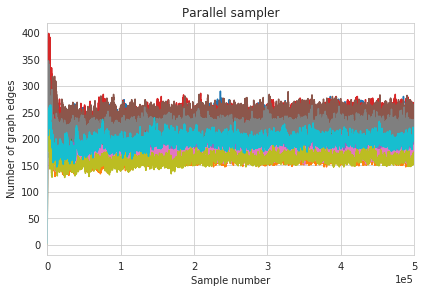

In [31]:
for f in paralleldg_files:
    size_traj_plot(f)
plt.title('Parallel sampler')
save_location('parallel_size_traceplot_10_traj')

In [5]:
acc_ratio_list =[]
for f in paralleldg_files:
    a, par = acceptance_ratio(size_traj(f)['size'])
    acc_ratio_list.append(a)


Acceptance ratio 0.134963
Acceptance ratio 0.058021
Acceptance ratio 0.136387
Acceptance ratio 0.138337
Acceptance ratio 0.119797
Acceptance ratio 0.133957
Acceptance ratio 0.083469
Acceptance ratio 0.114943
Acceptance ratio 0.068638
Acceptance ratio 0.093902


In [6]:
acc_ratio_list_sub =[]
for f in paralleldg_files_sub:
    a, par = acceptance_ratio(size_traj(f)['size'])
    acc_ratio_list_sub.append(a)


Acceptance ratio 0.100597
Acceptance ratio 0.061702
Acceptance ratio 0.085590
Acceptance ratio 0.069768
Acceptance ratio 0.100125
Acceptance ratio 0.043680
Acceptance ratio 0.050891
Acceptance ratio 0.091388
Acceptance ratio 0.100600
Acceptance ratio 0.104396


In [7]:
acc_ratio_list_gt =[]
for f in gt_files:
    a, par = acceptance_ratio(size_traj(f)['size'])
    acc_ratio_list_gt.append(a)


Acceptance ratio 0.029761
Acceptance ratio 0.041708
Acceptance ratio 0.024504
Acceptance ratio 0.026630
Acceptance ratio 0.026730
Acceptance ratio 0.028768
Acceptance ratio 0.037992
Acceptance ratio 0.023534
Acceptance ratio 0.040126
Acceptance ratio 0.027003


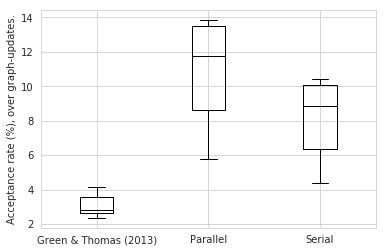

In [32]:
df = pd.DataFrame({'Parallel' : np.array(acc_ratio_list) * 100.0, 
              'Serial': np.array(acc_ratio_list_sub) * 100.0,
              'Green & Thomas (2013)': np.array(acc_ratio_list_gt) * 100.0
             })

ax = df.plot(kind='box',
             color=dict(boxes='black', whiskers='black', medians='black', caps='black'),
             #boxprops=dict(linestyle='-', linewidth=.5),
             #flierprops=dict(linestyle='-', linewidth=.5),
             #medianprops=dict(linestyle='-', linewidth=.5),
             #whiskerprops=dict(linestyle='-', linewidth=.5),
             #capprops=dict(linestyle='-', linewidth=.5),
             showfliers=False, grid=True, rot=0)

ax.set_ylabel('Acceptance rate (%), over graph-updates.')
save_location('gt_parallel_acceptance_rate_10_traj')



In [33]:
burnin = 300000
lag = 20000
data = dict()
for f in paralleldg_files:
    size = size_traj(f)
    burned = size['size'].values[-burnin:]
    data[f] = autocorrelation(burned, lag)

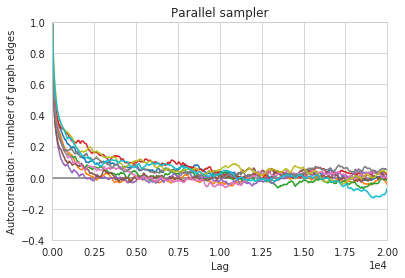

In [34]:
x = np.arange(lag) + 1
ax = plt.gca(xlim=(1, np.max(x)), ylim=(-1.0, 1.0))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation - number of graph edges")
for f in paralleldg_files:
    y = data[f]
    ax.plot(x, y)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Parallel sampler')
plt.ylim((-0.4, 1))
plt.xlim((0,20000))
save_location('parallel_autocorrelation_10_traj')

In [6]:
burnin = 500000
lag = 150000
data = dict()
for f in gt_files:
    size = size_traj(f)
    burned = size['size'].values[-burnin:]
    data[f] = autocorrelation(burned, lag)

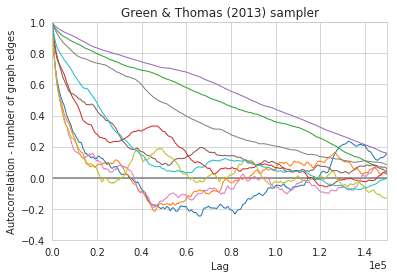

In [7]:
x = np.arange(lag) + 1
ax = plt.gca(xlim=(1, np.max(x)), ylim=(-1.0, 1.0))
ax.axhline(y=0.0, color="grey")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation - number of graph edges")
for f in gt_files:
    y = data[f]
    ax.plot(x, y, linewidth=1)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Green & Thomas (2013) sampler')
plt.ylim((-0.4, 1))
save_location('gt_autocorrelation_10_traj')